### Import libraries

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

### Dataset

In [3]:
# Dataset path
path = '/content/drive/MyDrive/data/News_Category_Dataset_v3.json'
# Create a list to store data
list_ = []
with open(path) as files:
  for file in files:
    list_.append(json.loads(file))

In [4]:
list_[:3]

[{'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9',
  'headline': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters',
  'category': 'U.S. NEWS',
  'short_description': 'Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.',
  'authors': 'Carla K. Johnson, AP',
  'date': '2022-09-23'},
 {'link': 'https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe',
  'headline': 'American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video',
  'category': 'U.S. NEWS',
  'short_description': "He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",
  'authors': 'Mary Papenfuss',
  'date': '2022-09-23'},
 {'link': 'https

In [5]:
# dataframe
df = pd.DataFrame(list_)
# check head
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [6]:
# check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               209527 non-null  object
 1   headline           209527 non-null  object
 2   category           209527 non-null  object
 3   short_description  209527 non-null  object
 4   authors            209527 non-null  object
 5   date               209527 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB


### EDA

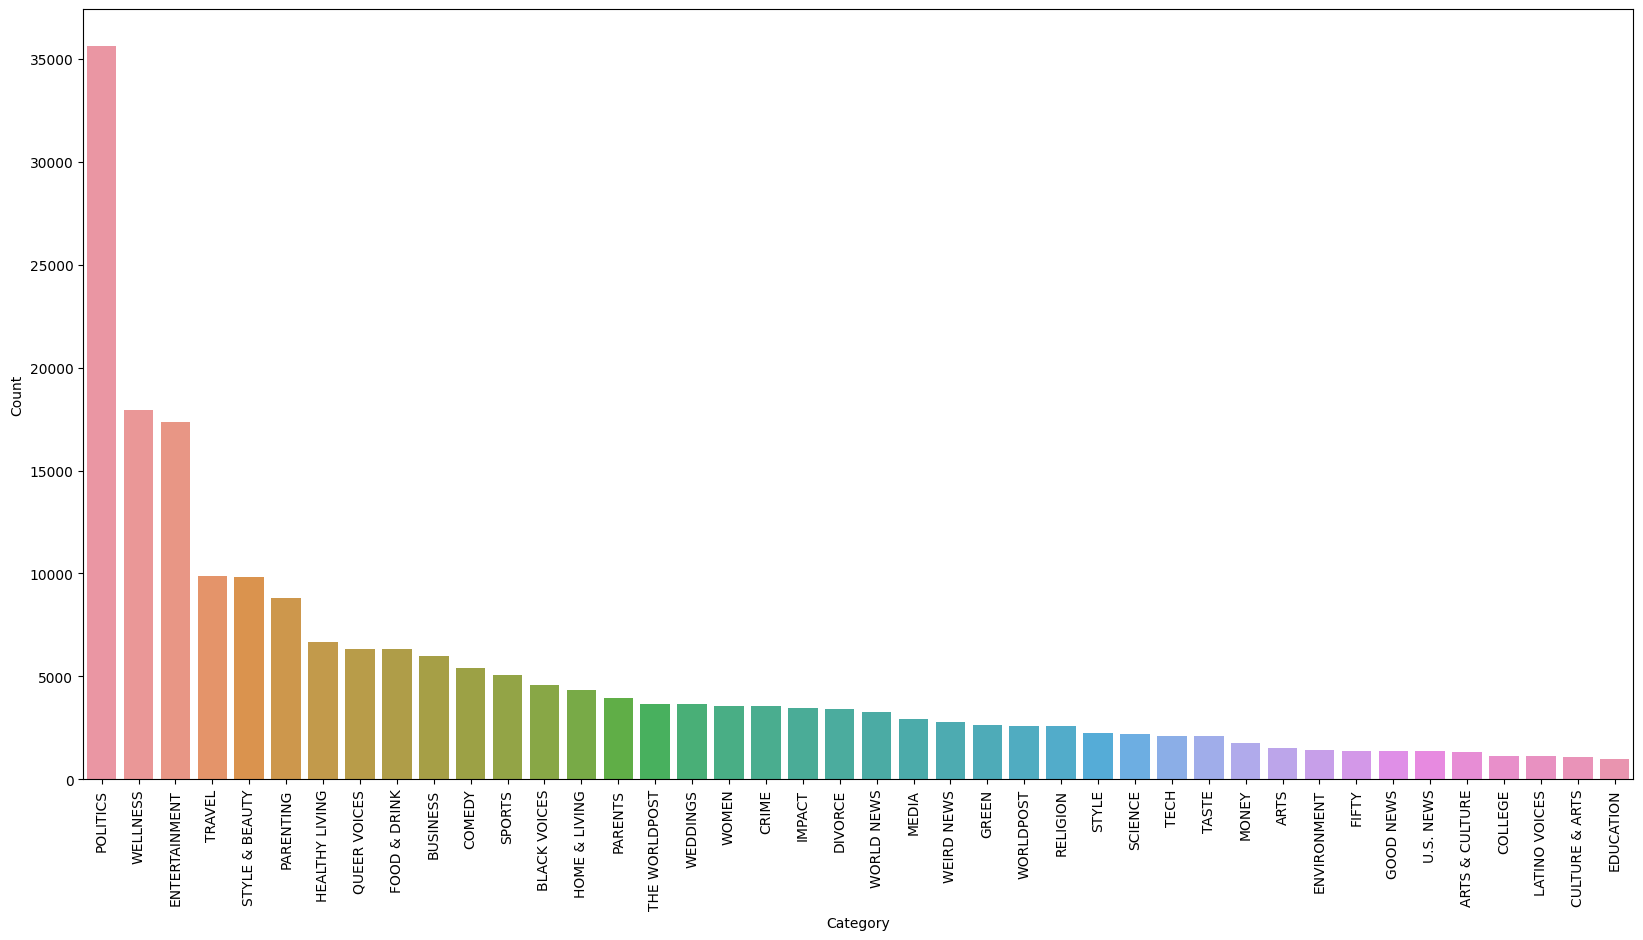

In [7]:
plt.figure(figsize=(20,10))
count = df.category.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90);

In [8]:
len(df['category'].unique()) # No of classes

42

### Data cleaning

In [9]:
def clean_data(text):
  text = text.lower() # lower sentence
  text = re.sub('<.*?>', '',text) # remove html tags
  text = re.sub(r'https?://\S+|www\.\S+','',text)#remove url
  text =  re.sub(r'pic.\S+', '',text) 
  text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
  text = "".join([i for i in text if i not in string.punctuation])
  words = nltk.tokenize.word_tokenize(text)
  stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
  text = " ".join([i for i in words if i not in stopwords and len(i)>2])
  text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
  return text


In [10]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Create new column by cleaning data
df['text_cleaning'] = df.headline.apply(clean_data)

In [12]:
# head
df.head()

,link,headline,category,short_description,authors,date,text_cleaning
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,million americans roll sleeves omicron targete...
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,american airlines flyer charged banned life pu...
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,funniest tweets cats dogs week sept
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,funniest tweets parents week sept
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,woman called cops black bird watcher loses law...


In [15]:
# Build pipeline
text_classification = Pipeline([
    ('vectorizer',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [17]:
# independent features
X = df['text_cleaning']
# Dependent features
y = df['category']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [18]:
text_classification.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [19]:
y_preds = text_classification.predict(X_test)
y_preds

array(['POLITICS', 'POLITICS', 'POLITICS', ..., 'POLITICS', 'WELLNESS',
       'POLITICS'], dtype='<U14')